'''

@Author: Jayesh Patil

@Date: 14-11-24

@Title: Logistic Regression to Predict Subscription to Term Deposit

'''

1.Based on bank customer data, predicted whether cutomer will subscribe to term deposit or not.

Importing Libraries

In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats


Load Dataset

In [18]:
df = pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Analize dataset

In [19]:
print(df.describe())
print("null values :",df.isna().sum())
print(df.info)
print("shape",df.shape)

               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  
null values : age 

Check for Outliers and Remove it

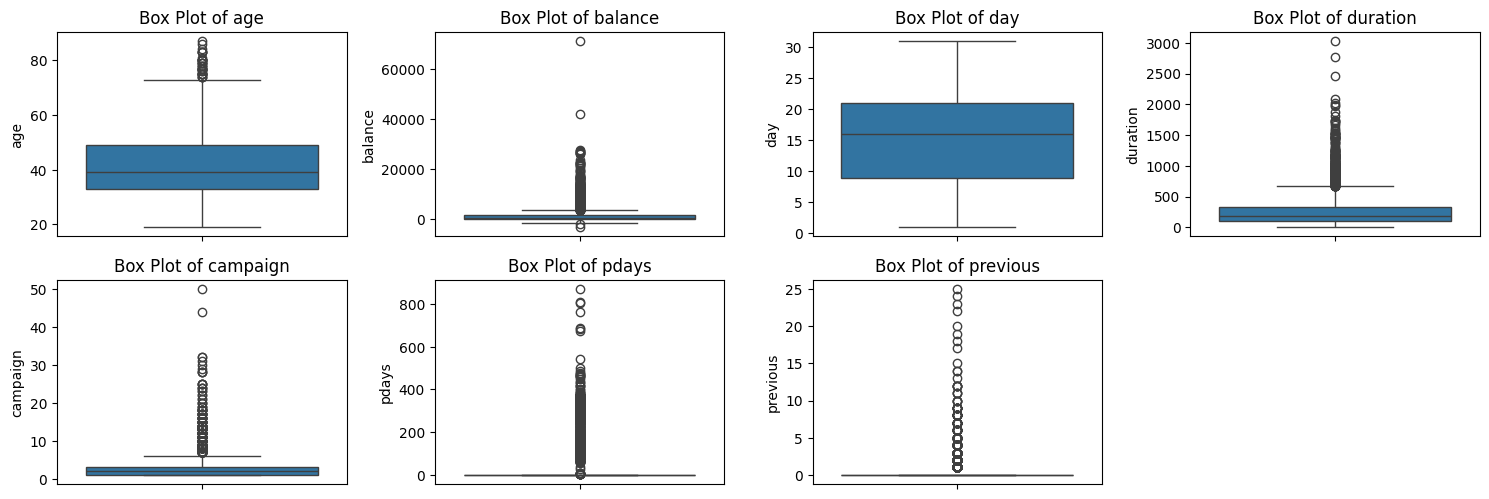

In [20]:
# Select only numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Visualizing the initial data with box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

In [21]:
z_scores = np.abs(stats.zscore(df[num_columns]))
df_filtered_z = df[(z_scores < 3 ).all(axis = 1)]
print(f'Original data shape: {df.shape}')
print(f'Filtered data shape (using Z-score): {df_filtered_z.shape}')

Original data shape: (4521, 17)
Filtered data shape (using Z-score): (3980, 17)


In [22]:
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtering the data to remove outliers
df_filtered_iqr = df[~((df[num_columns] < (Q1 - 1.5 * IQR)) | (df[num_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display the shape of the original and filtered data
print(f'Original data shape: {df.shape}')
print(f'Filtered data shape(using IQR): {df_filtered_iqr.shape}')

Original data shape: (4521, 17)
Filtered data shape(using IQR): (2803, 17)


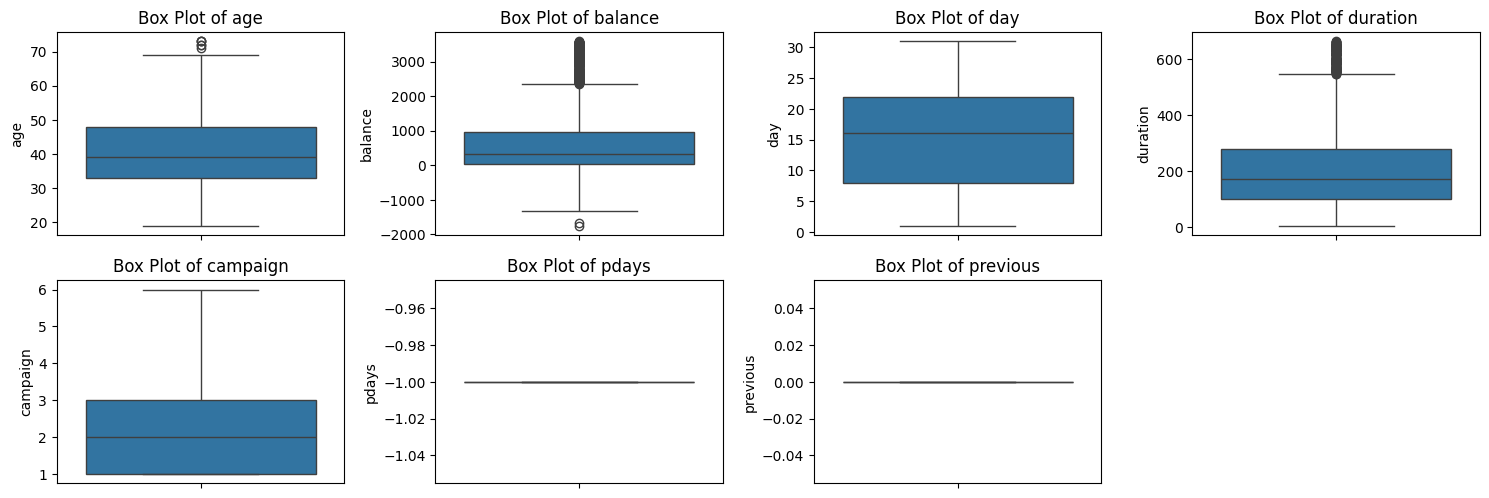

In [23]:
# Select only numerical columns
num_columns = df_filtered_iqr.select_dtypes(include=[np.number]).columns.tolist()

# Visualizing the initial data with box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df_filtered_iqr[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

Handle Catogircal data

In [24]:
label_encoders = {}
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for column in categorical_columns:
    le = LabelEncoder()
    df_filtered_iqr.loc[:, column] = le.fit_transform(df_filtered_iqr[column])  # Using .loc to avoid SettingWithCopyWarning
    label_encoders[column] = le  # Store the encoder for potential inverse transformation later

In [25]:
df_filtered_iqr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,0,no
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,0,no
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,0,no
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,0,no
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,36,9,0,1,0,566,1,0,2,20,8,129,2,-1,0,0,no
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2,-1,0,0,no
4513,49,1,1,1,0,322,0,0,0,14,1,356,2,-1,0,0,no
4515,32,7,2,1,0,473,1,0,0,7,5,624,5,-1,0,0,no


In [26]:
df_filtered_iqr.drop(columns=['pdays', 'previous', 'poutcome'], inplace=True)


C:\Users\Jayesh\AppData\Local\Temp\ipykernel_9612\3650862795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_iqr.drop(columns=['pdays', 'previous', 'poutcome'], inplace=True)


Split data in X and Y

In [27]:
y = df_filtered_iqr['y'].map({'yes':1 ,'no':0})
x = df_filtered_iqr.drop(columns=['y'])

In [28]:
x

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,30,10,1,0,0,1787,0,0,0,19,10,79,1
3,30,4,1,2,0,1476,1,1,2,3,6,199,4
4,59,1,1,1,0,0,1,0,2,5,8,226,1
7,39,9,1,1,0,147,1,0,0,6,8,151,2
8,41,2,1,2,0,221,1,0,2,14,8,57,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,36,9,0,1,0,566,1,0,2,20,8,129,2
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2
4513,49,1,1,1,0,322,0,0,0,14,1,356,2
4515,32,7,2,1,0,473,1,0,0,7,5,624,5


Check Corelation

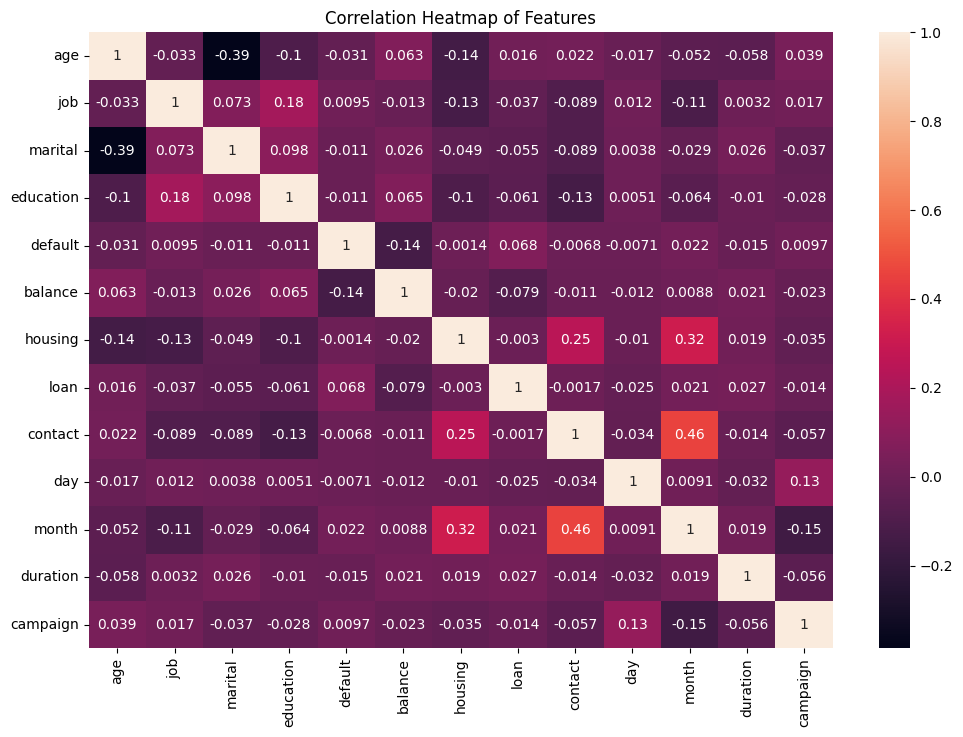

In [29]:
plt.figure(figsize=(12, 8))
correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap of Features')
plt.show()

Spit for Train Test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Selection

In [31]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)

Model Evalution

In [36]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_dict = classification_report(y_test, y_pred, output_dict=True)


print(f'Accuracy: {accuracy}')
print('Confusion Matrix:\n', conf_matrix)
print('class_report :\n',class_report_df)

Accuracy: 0.9554367201426025
Confusion Matrix:
 [[532   1]
 [ 24   4]]
class_report :
               precision    recall  f1-score     support
0              0.956835  0.998124  0.977043  533.000000
1              0.800000  0.142857  0.242424   28.000000
accuracy       0.955437  0.955437  0.955437    0.955437
macro avg      0.878417  0.570490  0.609734  561.000000
weighted avg   0.949007  0.955437  0.940378  561.000000


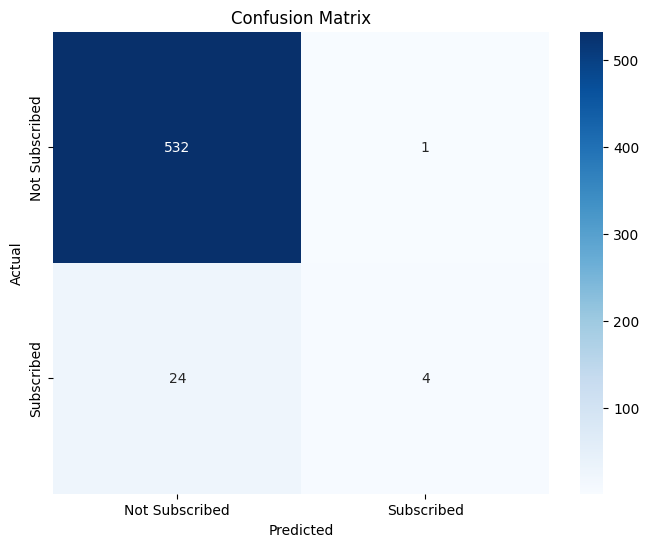

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

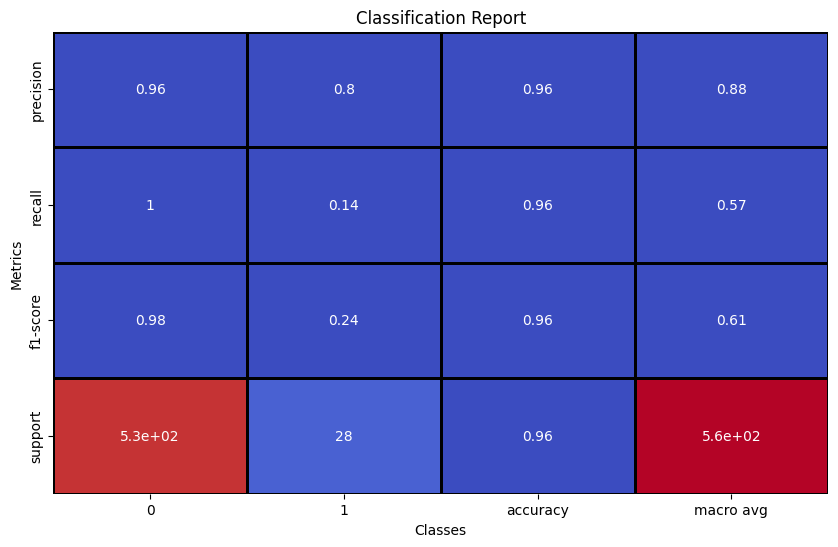

In [34]:
class_report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert to a DataFrame for plotting
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm',linecolor='black',linewidths='2' ,cbar=False)
plt.title("Classification Report")
plt.xlabel("Classes")
plt.ylabel("Metrics")
plt.show()